# Machine Learning on Graphs 

## Tools and library 

In this lab we start with the discovery of two popular libraries for analysing graphs, namely `scikit-network`, developped here at Télécom Paris,`networkx` and torch geometric. 

### Scikit-network

In [4]:
from IPython.display import SVG
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse

In [23]:
import sknetwork
from sknetwork.data import load_netset, linear_graph
from sknetwork.ranking import PageRank, top_k
from sknetwork.visualization import svg_graph
from sknetwork.utils import get_degrees

#### Import data

Cora is a directed citation network of 2708 papers with link as citation (citing paper points to cited paper, the order in the edgelist is reversed). Each paper has one label (7 types of label in total). The labels are:

    Case Based
    Genetic Algorithms
    Neural Networks
    Probabilistic Methods
    Reinforcement Learning
    Rule Learning
    Theory

Also, each papers has a binary feature vector of 1433 elements (word existance indicator) describing the content of the node. The end of each feature vector is the string label of the paper (e.g. Case_Based, or Neural_Networks). All nodes has label and feature vector.


In [7]:
cora = load_netset('cora')

Unpacking archive...
Parsing files...
Done.


In [8]:
# Let us take a closer look at the cora object
cora

{'labels': array([2, 2, 1, ..., 6, 6, 6]),
 'meta': {'name': 'Cora',
  'source': 'https://relational.fit.cvut.cz/dataset/CORA',
  'description': 'Graph of citations between scientific publications.',
  'long_description': 'Graph of citations between 2708 scientific publications on Machine Learning. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.',
  'date': '2008'},
 'biadjacency': <2708x1433 sparse matrix of type '<class 'numpy.bool_'>'
 	with 49216 stored elements in Compressed Sparse Row format>,
 'adjacency': <2708x2708 sparse matrix of type '<class 'numpy.bool_'>'
 	with 5429 stored elements in Compressed Sparse Row format>,
 'names': array([     35,      40,     114, ..., 1154524, 1154525, 1155073]),
 'names_labels': array(['Theory', 'Reinforcement Learning', 'Genetic Algorithms',
       

In [9]:
# We can then access to specific elements of the cora object as follow
lab = cora.labels
adj = cora.adjacency

**To do** : where are the node features ? 

In [10]:
features = cora.biadjacency

In [11]:
features

<2708x1433 sparse matrix of type '<class 'numpy.bool_'>'
	with 49216 stored elements in Compressed Sparse Row format>

In [12]:
adj

<2708x2708 sparse matrix of type '<class 'numpy.bool_'>'
	with 5429 stored elements in Compressed Sparse Row format>

Exemple

In [15]:
A = np.array([[0, 1, 1], [2, 0, 1], [1, 1, 0]])
A

array([[0, 1, 1],
       [2, 0, 1],
       [1, 1, 0]])

In [16]:
A_csr = sparse.csr_matrix(A)
A_csr

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [17]:
A_csr.data, A_csr.indices, A_csr.indptr

(array([1, 1, 2, 1, 1, 1]),
 array([1, 2, 0, 2, 0, 1], dtype=int32),
 array([0, 2, 4, 6], dtype=int32))

#### Description of the graph Cora

In [13]:
# Number of nodes and edges 
print("Number of nodes: ", adj.shape[0])
print("Number of links: ", adj.nnz)

Number of nodes:  2708
Number of links:  5429


In [21]:
# Number of nodes and edges
adj.shape

(2708, 2708)

**To do** : use the adjacency matrix to get the average out-degree.

In [22]:
adj.sum(axis=1)

matrix([[166],
        [  3],
        [ 42],
        ...,
        [  0],
        [  0],
        [  0]])

In [24]:
get_degrees(adj, transpose=True)

array([3, 1, 0, ..., 3, 3, 3], dtype=int32)

In [25]:
len(adj.data), len(adj.indices), len(adj.indptr)

(5429, 5429, 2709)

#### Visualization of the graph Cora

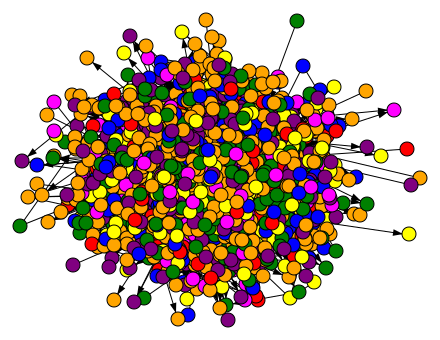

In [26]:
# Visualisation of the graph
image = svg_graph(adj, labels=lab)
SVG(image)

## Networkx

The second library is networkx. Documentation available [here](https://networkx.org/documentation/latest/).

In [29]:
import networkx as nx
import pandas as pd
import os

In [30]:
# Import the data 
# Compared to scikit-network, networkx does not allow to directly import some well-known graph

data_loc = 'cora/'  # 'cora.cites', 'cora.content'

edgelist = pd.read_csv(os.path.join(data_loc, "cora.cites"), sep='\t', header=None, names=["source", "target"])
edgelist["label"] = "cites"
    
# Let's take a quick look at the data 
edgelist.sample(frac=1).head(5)

,source,target,label
3660,75983,1115790,cites
4137,131117,152219,cites
5046,578669,1128943,cites
1181,6163,1113739,cites
2837,34263,87482,cites


In [32]:
# Convert the data to a directed graph
cora = nx.DiGraph()
cora.add_edges_from([(row.source, row.target) for _, row in edgelist.iterrows()])
nx.set_node_attributes(cora,  "paper", "label")

In [33]:
# We can also retrieve the node labels subject
cora_meta = os.path.expanduser(os.path.join(data_loc, "cora.content"))
node_attr = pd.read_csv(cora_meta, sep='\t', header=None)
values = { row.tolist()[0]: row.tolist()[-1] for _, row in node_attr.iterrows()}
nx.set_node_attributes(cora, values, 'subject')

#### Ready to describe the network 

We will follow the same steps as for scikit-network to describe the graph. Le networkx library offers more straighforward functions to obtain these caracteristics. 

In [34]:
print("Number of nodes: ", cora.number_of_nodes())
print("Number of edges: ", cora.number_of_edges())

Number of nodes:  2708
Number of edges:  5429


In [35]:
# We can also compute the degree of each node 
outdeg_cora = cora.out_degree()
indeg_cora = cora.in_degree()
deg_cora = cora.degree()

**To do**: check what is the type of deg_cora, then write a function to get the average degree of a graph 

In [ ]:
def average_degree(G):
    return np.mean([d for _, d in G.degree()])

In [ ]:
# Centrality measures 

## eigenvectors 
c_eig = nx.eigenvector_centrality(cora)

## closeness 
c_clo = nx.closeness_centrality(cora)

## betweeness 
c_bet = nx.betweenness_centrality(cora)

**To do** For each centrality measure and degree get the top-5 most important nodes. What do you observe?

## Node Embedding : DeepWalk

DeepWalk is a classic baseline for node embedding, based on random walks. Basically, a random walk is a way of converting a graph into a sequence of nodes. DeepWalk consists of two main steps: 
1. For each node in the graph, generate a random path of nodes connected 
2. From the corpus of random paths generated in step 1, train a skip-gram (Word2Vec) model 

In this part, we start by implementing the random walk ourselves (for understanding purpose), then use the Word2Vec implementation provided in `gensim`. Then, you will have to find a scalable implementation of the random-walk online and apply it to the full cora network (=what you'll have to do in companies !). 

In [ ]:
import random

# Convert Cora to an undirected network 
cora_u = cora.to_undirected()

### Random walk 

Our objective is to write a function, that given a graph, a specific node and the length of the walk, generate a random walk on the graph. The ouput of the function is a list of all the nodes composing the walk. To obtain the list of direct neighbors of a given node, you can use the function `all_neighbors` from the `networkx` package.

In [ ]:
import random 

walkLength = 10
startNode = list(cora_u.nodes)[0]

# Initialize the walk 
walk = [str(startNode)]
current_node = startNode
for _ in range(walkLength-1):
    # List of neighbors 
    neighbors = list(nx.all_neighbors(cora_u, current_node))
    # Select a random node as the next step in the walk 
    next_node = random.choice(neighbors)
    # Add the node to the walk 
    walk.append(str(next_node))
    # Update de position of the random walk 
    current_node = next_node

# Display the obtained walk
print(walk) 

**To do** What do you observe if you run the above cell multiple times ? Why ?

#### To do 

1. Define a function random_walk containing the steps above 
2. Explain the code given below. Then based on this latter, define a function RandomWalker that perform a given number of random walks per node and output a corpus of randomwalks (test with 2 random walks per node).

In [ ]:
def random_walk(g, node, wlen=10):
    # To do 
    return walk

walks = []
for node in cora.nodes():
    for _ in range(30):
        walks.append(random_walk(cora, node))

pd.DataFrame(walks) 

### Word2Vec 



In [ ]:
# Install the library 
# !pip install gensim

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# Initialise the model 
embedder = Word2Vec(
    window = 3,
    seed=42,
    sg=1,
    vector_size=32,
    hs=0, 
    negative=10, 
    alpha=0.02, 
    min_alpha=0.0001,
)

**To do** : take a look at all the hyper-parameters and check for their meaning in the documentation. 
Write in comments their role in the cell above. 

In [ ]:
# Next, we build the vocabulary out of the nodes 
embedder.build_vocab(walks,progress_per=2)
embedder.train(
    walks,
    total_examples=embedder.corpus_count, 
    epochs=4, 
)

vectors = pd.DataFrame({node: embedder.wv[node] for node in embedder.wv.key_to_index.keys()}).T

**To do** : display the shape of embedding matrix and the 3 first rows. 

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [ ]:
# Join embedding and label information
t = pd.DataFrame.from_dict(values, orient='index', columns=['label'])
t.index = t.index.astype(str)
h = vectors.join(t, how='left')
print(h.shape)
h.head()

In [ ]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_vectors = tsne_model.fit_transform(h.iloc[:,:-1])

**To do** : check the dimension of tsne_vectors and take a look at the documentation of TSNE to explain the hyper-parameters.

In [ ]:
# Plot 
x = tsne_vectors[:,0]
y = tsne_vectors[:,1]

# Retrieve labels for visualisation 
labels = h.iloc[:,-1:]
colors = cm.rainbow(np.linspace(0, 1, len(labels)))
plt.figure(figsize=(16, 16)) 
plt.scatter(x, y, label=labels, c=colors)
plt.show()

### To do 

1. Code improvement: define a class DeepWalk, which given a graph, the walk length, the number of walks per nodes and the desired dimension outputs the dataframe (or any object of your choice) of the embeddings. An option must allow to choose to visualize the obtained embedding with t-sne.

2. Use the obtained vectors as input data to learn a classifier (of your choice) to predict the **subject** of a paper. Note that, in our case we are only using the position of the paper in the graph and not the node features. 

3. Run Node2Vec on the same data and compare the obtained visualization and a classifier. You can choose the implementation/tool/librairy of your choice.